# Milestone Project 1: Food Vision Big


## Check GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-0d03af0b-2c1e-1a3f-13a8-2b71cc09abc0)


## Get helper functions


In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-04-16 21:33:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2025-04-16 21:33:18 (11.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow datasets to download data

In [4]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [5]:
# List available datasets
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [6]:
# Load data
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.RHHTCH_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.RHHTCH_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring data

In [7]:
# Features of Food101
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [8]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
# Take one sample of the train data
train_one_sample = train_data.take(1)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [10]:
# Output info about the training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Label: {label}
  Class name: {class_names[label]}
  """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Label: 49
  Class name: grilled_cheese_sandwich
  


In [11]:
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

# Plot an image from tensorflow datasets

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

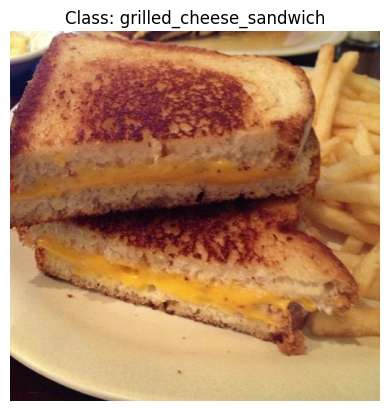

In [12]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(f"Class: {class_names[label]}")
plt.axis(False)

In [13]:
# Function for preprocessing images
def preprocess_image(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32'
  Resizes image to (img_shape, img_shape, color_channels)
  """
  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label

In [14]:
# Preprocess a single sample
preprocessed_image, label = preprocess_image(image, label)
preprocessed_image, label

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[238.7704   , 217.41327  , 155.4847   ],
         [242.83673  , 222.83673  , 162.55101  ],
         [240.85713  , 220.20918  , 164.2143   ],
         ...,
         [131.28564  , 118.28565  ,  75.7806   ],
         [123.88257  , 109.81113  ,  75.09689  ],
         [106.698746 ,  90.698746 ,  66.4131   ]],
 
        [[232.16325  , 212.09183  , 141.37755  ],
         [238.86224  , 219.86224  , 151.07654  ],
         [239.94388  , 221.08673  , 155.87245  ],
         ...,
         [127.49998  , 112.49998  ,  71.07145  ],
         [122.63767  , 106.56623  ,  72.852    ],
         [105.83142  ,  88.47424  ,  63.1886   ]],
 
        [[235.86224  , 217.07652  , 137.43367  ],
         [240.7143   , 223.7143   , 145.68367  ],
         [247.04591  , 229.26021  , 156.02551  ],
         ...,
         [126.68873  , 111.68873  ,  71.1173   ],
         [120.80094  , 104.7295   ,  71.01527  ],
         [105.57633  ,  88.29569  ,  62.581474

## Batch & prepare datasets

In [15]:
# Map preprocessing function to training data (and parallelize)
train_data = train_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data (and parallelize)
test_data = test_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

# Create modelling callbacks

In [26]:
# Create tensorboard callback (import from helper functions)
from helper_functions import create_tensorboard_callback

# Create model checkpoint call back
checkpoint_path = "model_checkpoints/cp..weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         monitor="val_accuracy",
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         verbose=0)

## Setup mixed precision training

In [18]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

## Build feature extraction model

In [19]:
from tensorflow.keras import layers
from tensorflow.keras import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32 (Activation)    │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [21]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype_policy)

input_layer True <DTypePolicy "mixed_float16">
efficientnetb0 False <DTypePolicy "mixed_float16">
global_average_pooling_layer True <DTypePolicy "mixed_float16">
dense True <DTypePolicy "mixed_float16">
softmax_float32 True <DTypePolicy "float32">


In [22]:
for layer in model.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype_policy)

input_layer False <DTypePolicy "mixed_float16">
rescaling False <DTypePolicy "mixed_float16">
normalization False <DTypePolicy "mixed_float16">
rescaling_1 False <DTypePolicy "mixed_float16">
stem_conv_pad False <DTypePolicy "mixed_float16">
stem_conv False <DTypePolicy "mixed_float16">
stem_bn False <DTypePolicy "mixed_float16">
stem_activation False <DTypePolicy "mixed_float16">
block1a_dwconv False <DTypePolicy "mixed_float16">
block1a_bn False <DTypePolicy "mixed_float16">
block1a_activation False <DTypePolicy "mixed_float16">
block1a_se_squeeze False <DTypePolicy "mixed_float16">
block1a_se_reshape False <DTypePolicy "mixed_float16">
block1a_se_reduce False <DTypePolicy "mixed_float16">
block1a_se_expand False <DTypePolicy "mixed_float16">
block1a_se_excite False <DTypePolicy "mixed_float16">
block1a_project_conv False <DTypePolicy "mixed_float16">
block1a_project_bn False <DTypePolicy "mixed_float16">
block2a_expand_conv False <DTypePolicy "mixed_float16">
block2a_expand_bn False

## Fit the feature extraction model

In [27]:
# Fit the feature extraction model with callbacks
history_101_food_classes_feature_extraction = model.fit(train_data,
                                       epochs=3,
                                       steps_per_epoch=len(train_data),
                                       validation_data=test_data,
                                       validation_steps=int(0.15 * len(test_data)),
                                       callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                             experiment_name="efficientnetb0_feature_extraction"),
                                                  checkpoint_callback])

Saving TensorBoard log files to: training_logs/efficientnetb0_feature_extraction/20250416-220904
Epoch 1/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 168s 70ms/step - accuracy: 0.7242 - loss: 1.0431 - val_accuracy: 0.7301 - val_loss: 0.9835
Epoch 2/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 200s 84ms/step - accuracy: 0.7394 - loss: 0.9768 - val_accuracy: 0.7352 - val_loss: 0.9643
Epoch 3/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 160s 66ms/step - accuracy: 0.7555 - loss: 0.9207 - val_accuracy: 0.7386 - val_loss: 0.9607


In [28]:
results_feature_extraction = model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 45s 57ms/step - accuracy: 0.7335 - loss: 0.9668


In [25]:
results_feature_extraction

[0.9934285879135132, 0.7307722568511963]